# Functional Connectivity

**Load Data**

In [3]:
import scipy.io as sio
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from tqdm import tnrange, tqdm_notebook
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import maxabs_scale, minmax_scale
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Lasso, LassoLars, LassoLarsIC 
from sklearn.linear_model import OrthogonalMatchingPursuit, ElasticNet
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns
import time, warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid',palette='cividis')

In [10]:
# Normalized
rdata = sio.loadmat('D:/ML/data/Data_normalized/rData.mat')['rData_all'].T
cdata = sio.loadmat('D:/ML/data/Data_normalized/cData.mat')['cData_all'].T
xdata = sio.loadmat('D:/ML/data/Data_normalized/xData.mat')['xData_all'].T
pdata = sio.loadmat('D:/ML/data/Data_normalized/pData.mat')['pData_all'].T
# Original
# rdata = sio.loadmat('D:/ML/data/Data_original/rData.mat')['rData_all'].T
cdata_raw = sio.loadmat('D:/ML/data/Data_original/cData.mat')['cData_all'].T
# xdata = sio.loadmat('D:/ML/data/Data_original/xData.mat')['xData_all'].T
# pdata = sio.loadmat('D:/ML/data/Data_original/pData.mat')['pData_all'].T
cdata.shape

(176, 6670)

In [5]:
# Labels
pos = sio.loadmat('D:/ML/data/PANSS_original/posPANSS.mat')['pos_all'].T
neg = sio.loadmat('D:/ML/data/PANSS_original/negPANSS.mat')['neg_all'].T
gen = sio.loadmat('D:/ML/data/PANSS_original/genPANSS.mat')['gen_all'].T
tot = sio.loadmat('D:/ML/data/PANSS_original/totPANSS.mat')['tot_all'].T
score = np.hstack((pos,neg,gen,tot))
score.shape

(176, 4)

In [6]:
cdata_maxabs = maxabs_scale(cdata_raw,axis=0)
pos_maxabs = maxabs_scale(pos,axis=0)
pos_minmax = minmax_scale(pos,axis=0)

## Data Observation
### Correlation

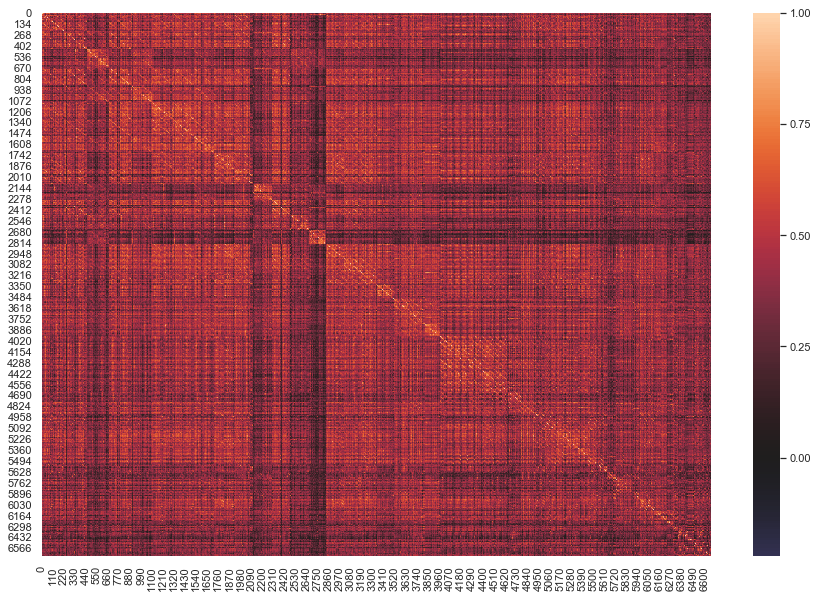

In [5]:
c_corr = pd.DataFrame(data=np.hstack((cdata,score))).corr()
plt.figure(figsize=(15,10))
ax = sns.heatmap(c_corr.loc[0:6669,0:6669],center=0)
plt.show()

**Mean Values across every 115 features**

In [7]:
def mean_features(data, stepsize):
    tmp1 = []
    length = data.shape[1]
    num  = int(length/stepsize)
    for i in range(0,num):
        mean = np.mean(data[:,i*stepsize:(i+1)*stepsize-1],
                       axis=1)
        tmp1.append(mean)
    tmp = np.array(tmp1).reshape(num,176).T
    return tmp

cdata_m = mean_features(cdata, 115)
pd.DataFrame(cdata_m).describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,...,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,0.511784,0.510227,0.491552,0.481616,0.469134,0.493379,0.502264,0.487793,0.488803,0.483286,...,0.482131,0.503806,0.543286,0.515042,0.480140,0.504512,0.518837,0.493520,0.496973,0.515142
std,0.131411,0.126658,0.127977,0.130732,0.140201,0.134607,0.132512,0.133084,0.133424,0.131831,...,0.124183,0.118038,0.120643,0.119406,0.135095,0.127862,0.116308,0.116477,0.119959,0.112277
min,0.213579,0.178741,0.237067,0.232777,0.203855,0.175282,0.229473,0.228914,0.177077,0.223869,...,0.233775,0.242827,0.183487,0.270836,0.191892,0.250118,0.261161,0.255430,0.228678,0.274894
25%,0.405616,0.411393,0.400919,0.376264,0.367698,0.397894,0.399742,0.379935,0.391444,0.384969,...,0.398367,0.414563,0.459490,0.431278,0.379066,0.413430,0.439147,0.402676,0.406914,0.429021
50%,0.484593,0.494314,0.467919,0.460494,0.459619,0.485840,0.482793,0.478320,0.462493,0.463821,...,0.467469,0.487957,0.534573,0.501828,0.459165,0.486703,0.499806,0.482814,0.487907,0.505929
75%,0.607615,0.603274,0.572231,0.569100,0.542500,0.572915,0.600691,0.573313,0.579270,0.571404,...,0.566980,0.577199,0.634167,0.604978,0.574324,0.592051,0.598085,0.572129,0.587198,0.592158
max,0.822001,0.819712,0.864575,0.840032,0.882719,0.859297,0.887280,0.832951,0.856346,0.901918,...,0.825514,0.832740,0.890694,0.831569,0.819646,0.837351,0.835554,0.813981,0.783979,0.828874


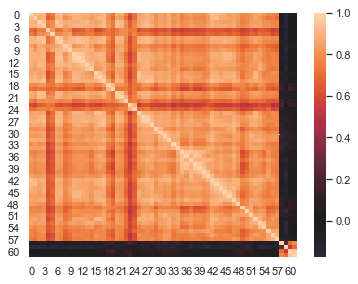

In [10]:
cm_corr = pd.DataFrame(np.hstack((cdata_m,score))).corr()
plt.figure(figsize=(6,4.5))
ax = sns.heatmap(cm_corr,center=0)

**PANSS and individual features**

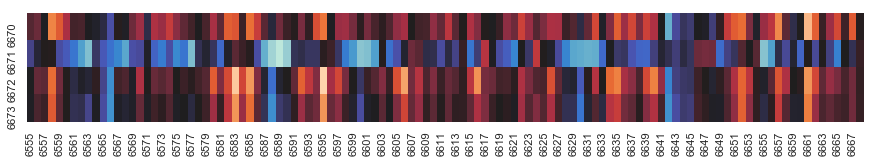

In [13]:
def palplot_corr(df, stepsize):
    length = df.shape[1]
    num  = int(length/stepsize)
    for i in range(0,num):
        tmp = df.iloc[:,i*stepsize:(i+1)*stepsize-1]
        sns.heatmap(tmp,cbar=False,center=0)

plt.figure(figsize=(15,2))
palplot_corr(c_corr.loc[6670:6673,0:6669], 115)

### Distribution

In [14]:
pd.DataFrame(cdata).describe()

,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,...,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,0.531841,0.511575,0.498906,0.506896,0.500815,0.522045,0.608613,0.550756,0.535239,0.574606,...,0.549578,0.513323,0.541937,0.546405,0.514209,0.518083,0.567699,0.491415,0.544546,0.416903
std,0.175003,0.212806,0.221103,0.194806,0.173199,0.221123,0.203412,0.191213,0.181751,0.200671,...,0.155468,0.172238,0.182176,0.179843,0.191755,0.186441,0.183070,0.188976,0.184927,0.170894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.411198,0.351699,0.328294,0.374326,0.397849,0.360462,0.471025,0.433337,0.415444,0.451939,...,0.451538,0.392548,0.394067,0.411077,0.412221,0.386370,0.422439,0.366792,0.408617,0.301314
50%,0.538520,0.506217,0.512635,0.480661,0.486881,0.515556,0.591637,0.518072,0.524849,0.584598,...,0.548888,0.506119,0.547604,0.556185,0.538613,0.502794,0.560325,0.484597,0.544277,0.407935
75%,0.665578,0.653366,0.639768,0.638905,0.613747,0.670575,0.762231,0.680288,0.654160,0.713933,...,0.662217,0.638846,0.657568,0.677193,0.632650,0.630528,0.697684,0.617509,0.673399,0.533648
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, '$\\Phi(x_2)$')

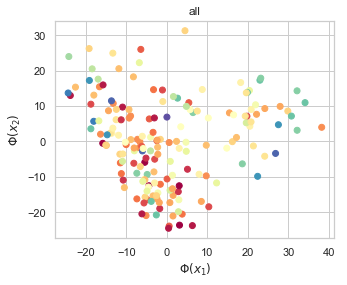

In [12]:
data = np.hstack((rdata,cdata,xdata,pdata))
pca = PCA(n_components=2)
A = pca.fit_transform(data)
plt.figure(figsize=(5,4))
plt.title('all')
plt.scatter(A[:,0],A[:,1],c=np.ravel(pos),cmap='Spectral')
plt.xlabel('$\Phi(x_1)$')
plt.ylabel('$\Phi(x_2)$')

(176,)

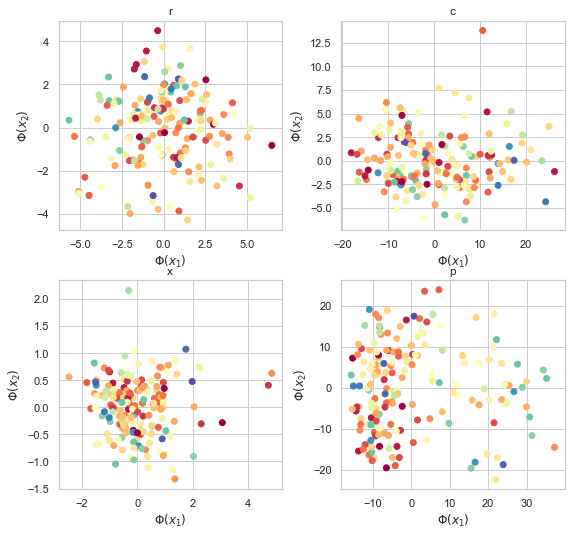

In [13]:
a = pca.fit_transform(rdata)
plt.figure(figsize=(8,7))
plt.subplot(2,2,1)
plt.title('r')
plt.scatter(a[:,0],a[:,1],c=np.ravel(pos),cmap='Spectral')
plt.xlabel('$\Phi(x_1)$')
plt.ylabel('$\Phi(x_2)$')

b = pca.fit_transform(cdata)
plt.subplot(2,2,2)
plt.title('c')
plt.scatter(b[:,0],b[:,1],c=np.ravel(pos),cmap='Spectral')
plt.xlabel('$\Phi(x_1)$')
plt.ylabel('$\Phi(x_2)$')
plt.tight_layout()

c = pca.fit_transform(xdata)
plt.subplot(2,2,3)
plt.title('x')
plt.scatter(c[:,0],c[:,1],c=np.ravel(pos),cmap='Spectral')
plt.xlabel('$\Phi(x_1)$')
plt.ylabel('$\Phi(x_2)$')
plt.subplot(2,2,4)

d = pca.fit_transform(pdata)
plt.title('p')
plt.scatter(d[:,0],d[:,1],c=np.ravel(pos),cmap='Spectral')
plt.xlabel('$\Phi(x_1)$')
plt.ylabel('$\Phi(x_2)$')
np.ravel(pos).shape

## Feature Selection (A): From Models
**Models**
- Lasso:
$$\frac{1}{2n_{samples}}\|\mathbf{y} - \mathbf{Xw}\|^2_2 + \alpha\|\mathbf{w}\|_1$$

- Elastic Net:
$$1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2$$

|Algorithm|Description|
|--|--|
|Coordinate Descent (LassoCD)|null|
|Least Angle Regression (LassoLARS)|null|
|Information Criterion Based LARS (LassoLARSIC)|AIC/BIC|
|Elastic Net|null|

**Results**

|PANSS|alpha|R|
|--|--|--|
|Positive|0.05|0.12|
|Negative|||
|General|||
|Total|||

### Lasso
**LassoCD**

In [31]:
def single_kernel_alpha(data, label, step, scale, state):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    X = data
    y = label
    r2=[]
    ilist=[]
    pbar = tnrange(step, desc='loop')
    for i in np.linspace(1,900,step)*scale:
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            clf = Lasso(alpha=i)
            clf.fit(X_train_tmp, np.ravel(y_train))
            feature_index = np.where(clf.coef_>0)[0]
            X_train = X_train_tmp[:,feature_index]
            X_test = X_test_tmp[:,feature_index]

            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
        r2.append(np.mean(r2_single))
        ilist.append(i)
        pbar.update(1)
    pbar.close()
    plt.figure()
    plt.plot(r2)
    plt.xlabel('$alpha$(x'+str(scale)+')')
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', alpha=',a)
    return r2,ilist

In [21]:
clf = Lasso(alpha=0.1)
clf.fit(cdata, np.ravel(pos))
feature_index = np.where(clf.coef_>0)[0]
len(feature_index)

21

**Case 0: [0,1] Normalized data | Raw labels**

max r2_score= 0.013835856909988387 , alpha= 0.04979346733668342


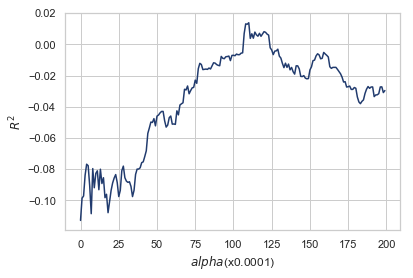

In [38]:
c_r2, c_a = single_kernel_alpha(cdata, pos, 200, 1e-4)

max r2_score= -0.13361426177877386 , alpha= 0.02810904522613065


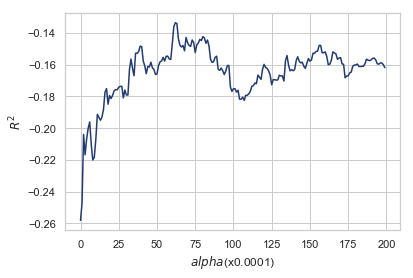

In [37]:
c_r2, c_a = single_kernel_alpha(cdata, neg, 200, 1e-4, 999)

max r2_score= -0.020116114835563748 , alpha= 0.011393969849246231


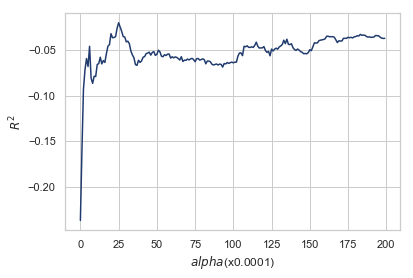

In [86]:
c_r2, c_a = single_kernel_alpha(cdata, gen, 200, 1e-4)

max r2_score= -0.05010488850627672 , alpha= 0.022687939698492463


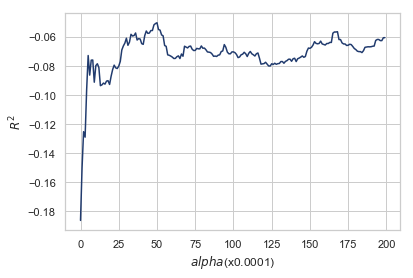

In [36]:
c_r2, c_a = single_kernel_alpha(cdata, tot, 200, 1e-4, 999)

**Case 1: Raw data | Raw labels**

max r2_score= -0.11451351945484996 , alpha= 0.005476281407035177


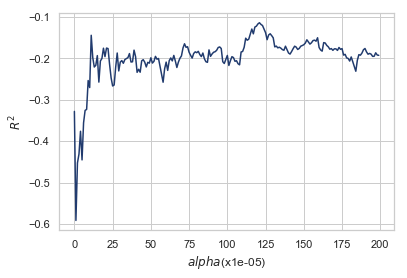

In [61]:
c_r2_, c_a_ = single_kernel_alpha(cdata_raw, pos, 200, 1e-5)

**Case 2: [0,1] Normalized data | [0,1] Normalized labels**

max r2_score= -0.0433975913343963 , alpha= 0.0035788944723618094


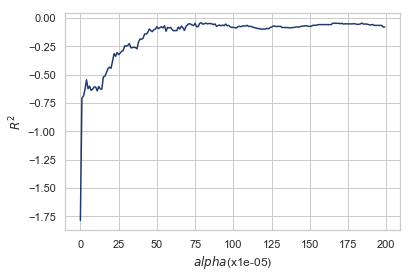

In [59]:
c_r2, c_a = single_kernel_alpha(cdata, pos_minmax, 200, 1e-5)

max r2_score= -0.05693976157524241 , alpha= 0.00642497487437186


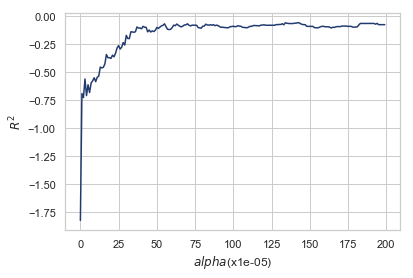

In [8]:
c_r2, c_a = single_kernel_alpha(cdata, pos_maxabs, 200, 1e-5)

**Case 3: [-1,1] Normalized data | [-1,1] Normalized labels**

max r2_score= -0.032982418793134606 , alpha= 0.004166180904522613


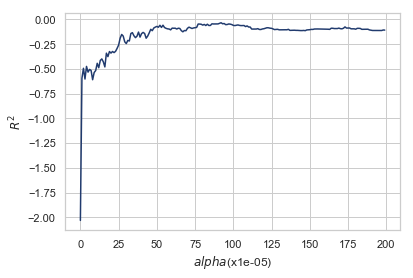

In [63]:
c_r2, c_a = single_kernel_alpha(cdata_maxabs, pos_maxabs, 200, 1e-5)

**LassoLARS**

In [13]:
def single_kernel_lars(data, label, step, scale, state):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    X = data
    y = label
    r2=[]
    ilist=[]
    sublist=[]
    pbar = tnrange(step, desc='loop')
    for i in np.linspace(1,900,step)*scale:
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            clf = LassoLars(alpha=i)
            clf.fit(X_train_tmp, np.ravel(y_train))
            feature_index = np.where(clf.coef_>0)[0]
            X_train = X_train_tmp[:,feature_index]
            X_test = X_test_tmp[:,feature_index]

            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
        r2.append(np.mean(r2_single))
        ilist.append(i)
        pbar.update(1)
    pbar.close()
    plt.figure()
    plt.plot(r2)
    plt.xlabel('$alpha$(x'+str(scale)+')')
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', alpha=',a)
    return r2,ilist

max r2_score= 0.0018950218750072745 , alpha= 0.030819597989949744


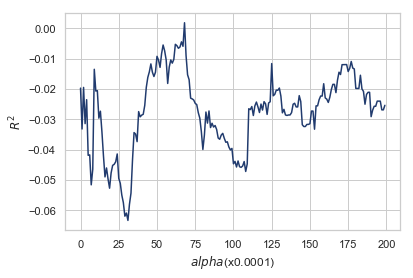

In [75]:
c_r2, c_a = single_kernel_lars(cdata, pos, 200, 1e-4)

max r2_score= -0.1270096786933317 , alpha= 0.016445454545454548


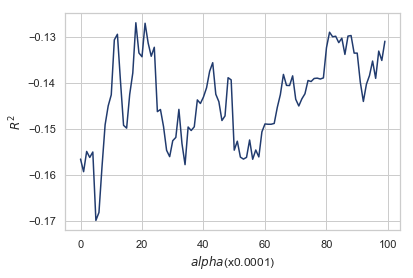

In [15]:
c_r2, c_a = single_kernel_lars(cdata, neg, 100, 1e-4, 999)

max r2_score= -0.020660617369203327 , alpha= 0.002461818181818182


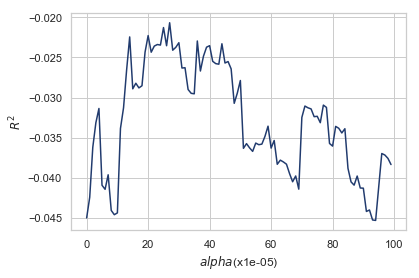

In [17]:
c_r2, c_a = single_kernel_lars(cdata, gen, 100, 1e-5, 999)

max r2_score= -0.05630177337604368 , alpha= 0.008272727272727274


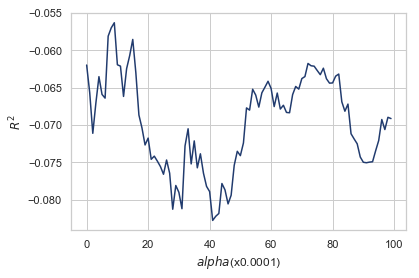

In [18]:
c_r2, c_a = single_kernel_lars(cdata, tot, 100, 1e-4, 999)

**LassoLARS-AIC**

Unable to compute cdata

In [59]:
def lassolars_ic(data, label):
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    X = data
    y = label
    r2=[]
    ilist=[]
    for train_index, test_index in kf.split(X):
        y_train, y_test = y[train_index], y[test_index]
        X_train_tmp, X_test_tmp = X[train_index], X[test_index]
        reg = linear_model.LassoLarsIC(criterion='aic', normalize=False)
        reg.fit(X_train_tmp,y_train)
        feature_index = np.where(reg.coef_>0)[0]
        X_train = X_train_tmp[:,feature_index]
        X_test = X_test_tmp[:,feature_index]
        svr = svm.SVR(kernel='linear')
        svr.fit(X_train, np.ravel(y_train))
        r2.append(svr.score(X_test,np.ravel(y_test)))
    print('mean r2_score=',np.mean(r2))
    return r2

In [60]:
cr_2 = lassolars_ic(xdata, pos)

mean r2_score= 0.02130720850939506


### Elastic Net

In [94]:
from sklearn.linear_model import ElasticNet
def elastic_net(data, label, step, scale, ratio):
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    X = data
    y = label
    r2=[]
    ilist=[]
    pbar = tnrange(step, desc='loop')
    for i in np.linspace(9.05,9.25,step)*scale:
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            regr = ElasticNet(random_state=999,alpha=i,l1_ratio=ratio)
            regr.fit(X_train_tmp, np.ravel(y_train))
            feature_index = np.where(regr.coef_>0)[0]
            X_train = X_train_tmp[:,feature_index]
            X_test = X_test_tmp[:,feature_index]

            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
        r2.append(np.mean(r2_single))
        ilist.append(i)
        pbar.update(1)
    pbar.close()
    plt.figure()
    plt.plot(np.linspace(9.05,9.25,step)*scale,r2)
    plt.xlabel('$alpha$')
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', alpha=',a)
    return r2,ilist

In [96]:
def elastic_net(data, label, step, scale, al):
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    X = data
    y = label
    r2=[]
    ilist=[]
    pbar = tnrange(step, desc='loop')
    for i in np.linspace(9,9.05,step)*scale:
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            regr = ElasticNet(random_state=999,alpha=al,l1_ratio=i)
            regr.fit(X_train_tmp, np.ravel(y_train))
            feature_index = np.where(regr.coef_>0)[0]
            X_train = X_train_tmp[:,feature_index]
            X_test = X_test_tmp[:,feature_index]

            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
        r2.append(np.mean(r2_single))
        ilist.append(i)
        pbar.update(1)
    pbar.close()
    plt.figure()
    plt.plot(np.linspace(9,9.05,step)*scale,r2)
    plt.xlabel('$alpha$')
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', alpha=',a)
    return r2,ilist

max r2_score= 0.04550556213438546 , alpha= 0.0916578947368421


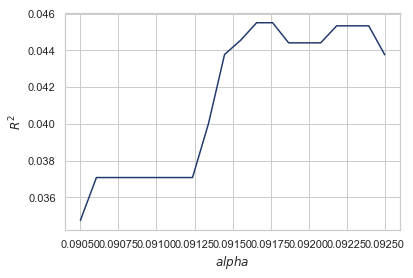

In [95]:
c_r2, c_a = elastic_net(cdata, pos, 20, 1e-2, 0.902)

max r2_score= 0.04550556213438546 , alpha= 0.901842105263158


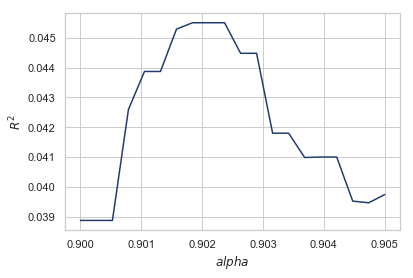

In [98]:
c_r2, c_a = elastic_net(cdata, pos, 20, 1e-1, 0.0917)

### Other Models
**OMP**

In [41]:
def single_kernel_omp(data, label,scale):
    X = data
    y = label
    kf = KFold(n_splits=10,shuffle=False)
    r2=[]
    ilist=[]
    pbar = tnrange(199, desc='loop')
    for i in np.ceil(np.arange(1,200)**scale).astype(int):
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            clf = OrthogonalMatchingPursuit(n_nonzero_coefs=i,normalize=False)
            clf.fit(X_train_tmp, np.ravel(y_train))
            feature_index = np.where(clf.coef_>0)[0]
            X_train = X_train_tmp[:,feature_index]
            X_test = X_test_tmp[:,feature_index]

            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
        r2.append(np.mean(r2_single))
        ilist.append(i)
        pbar.update(1)
    pbar.close()
    plt.figure()
    plt.plot(np.ceil(np.arange(1,200)**scale).astype(int),r2)
    plt.xlabel('Number of features')
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', alpha=',a)
    return r2,ilist

max r2_score= -0.3817617395528147 , alpha= 4


([-0.44429814879036567,
  -0.3852215598898908,
  -0.3817617395528147,
  -0.4054550910524185,
  -0.4262706457694742,
  -0.4550840285139823,
  -0.45901945458637716,
  -0.44021307664192405,
  -0.44282149741859345,
  -0.4453131053454369,
  -0.433165050921522,
  -0.4435786275511143,
  -0.4456318811008339,
  -0.4494767556423268,
  -0.46403080329709245,
  -0.48482167963389544,
  -0.46048323227774224,
  -0.44125494523271475,
  -0.4662033055027222,
  -0.46847644777323777,
  -0.47547061083616227,
  -0.4302223343671299,
  -0.42733587920743865,
  -0.47860689441862425,
  -0.48759463096749844,
  -0.5251297593779369,
  -0.548052373681025,
  -0.5384135950495893,
  -0.5711536974195035,
  -0.6239914930312422,
  -0.6721650916814819,
  -0.6886834528182714,
  -0.6540603827121025,
  -0.6646879459927215,
  -0.6615215439249129,
  -0.654267623664869,
  -0.6119348944430157,
  -0.6110223860219827,
  -0.6516862025273931,
  -0.6604625360272851,
  -0.6443667574365521,
  -0.6234141720394321,
  -0.6277253583598863,
 

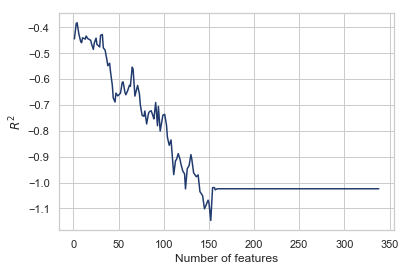

In [57]:
single_kernel_omp(cdata_maxabs, pos_maxabs, 1.1)

**RBF Sampler**

In [49]:
def single_kernel_rbf(data, label, scale):
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    X = data
    y = label
    r2=[]
    ilist=[]
    sublist=[]
    pbar = tnrange(300, desc='loop')
    for i in np.ceil(np.arange(0.1,300)**scale).astype(int):
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            rbf_feature = RBFSampler(gamma=1/i, random_state=999)
            rbf_feature.fit(X_train_tmp)
            X_train = rbf_feature.transform(X_train_tmp)
            X_test = rbf_feature.transform(X_test_tmp)
            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
            
        r2.append(np.mean(r2_single))
        ilist.append(i)
        pbar.update(1)
    pbar.close()
    plt.figure()
    plt.plot(np.ceil(np.arange(0.1,300)**scale).astype(int),r2)
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', gamma=',a)
    return r2,ilist

max r2_score= 0.0018376193578192202 , gamma= 77


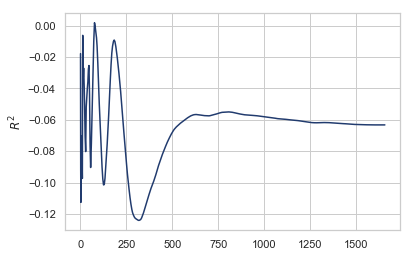

In [55]:
cr2__,c_a__ = single_kernel_rbf(cdata, pos, 1.3)

max r2_score= -0.0015988760223937248 , gamma= 99


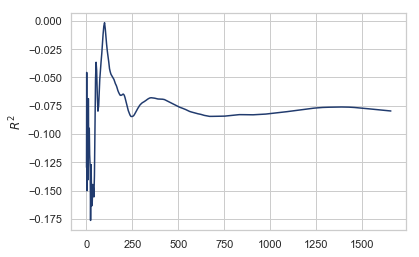

In [54]:
cr2__,c_a__ = single_kernel_rbf(cdata, neg, 1.3)

max r2_score= -0.00833873470136004 , gamma= 26


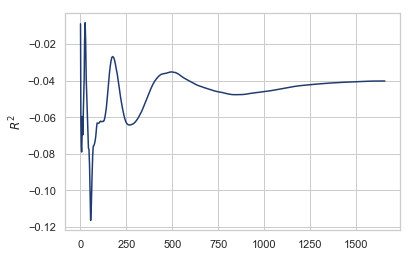

In [53]:
cr2__,c_a__ = single_kernel_rbf(cdata, gen, 1.3)

max r2_score= -0.02056583196964217 , gamma= 26


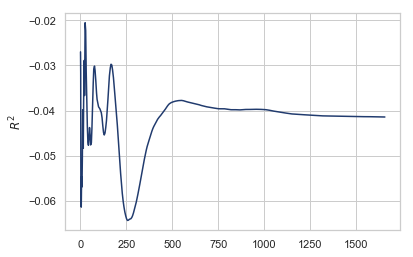

In [52]:
cr2__,c_a__ = single_kernel_rbf(cdata, tot, 1.3)

### Tree Based Method

In [78]:
def reg_tree(data, label, lower_n_features, upper_n_features, fig_on_row):
    X = data
    y = label
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    pbar = tnrange((upper_n_features-lower_n_features)*10, desc='loop')
    r2=[]
    mat=[]
    ilist=[]
    for train_index, test_index in kf.split(X):
        y_train, y_test = y[train_index], y[test_index]
        X_train_tmp, X_test_tmp = X[train_index], X[test_index]
        r2_single=[]
        i_single=[]
        scale = range(lower_n_features,upper_n_features)
        svr = svm.SVR(kernel='linear')
        reg = DecisionTreeRegressor(random_state=999)
        reg.fit(X_train_tmp,y_train)
        importance = np.argsort(reg.feature_importances_)
        mat.append(reg.feature_importances_)
        for i in scale:
            X_train = X_train_tmp[:,importance[:i]]
            X_test = X_test_tmp[:,importance[:i]]
            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, y_train)
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
            i_single.append(i)
            pbar.update(1)
        r2.append(np.max(r2_single))
        a = np.where(r2_single==max(r2_single))[0]
        ilist.append(i_single[a[0]])
    mat = np.array(mat)
    for j in range(int(X.shape[1]/fig_on_row)):
        tmp = mat[:,j*fig_on_row:(j+1)*fig_on_row-1]
        plt.matshow(tmp, cmap=plt.cm.Blues)
        plt.title("Ranking of pixels with 10-fold RFE("+str(j*fig_on_row)+'th to'+str((j+1)*fig_on_row-1)+'th features)')
        plt.tight_layout
#         plt.colorbar()
    pbar.close()
    plt.show()    
    print('mean r2_score=',np.mean(r2),', number of selected features=',ilist)
    return r2

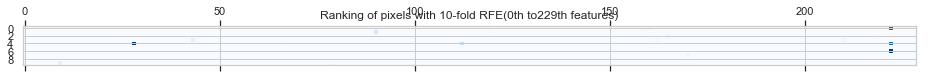

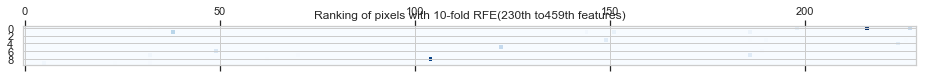

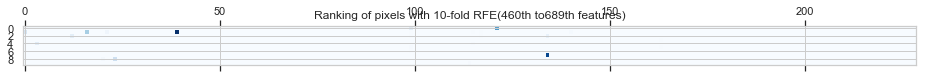

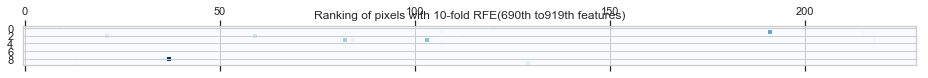

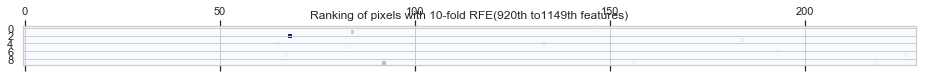

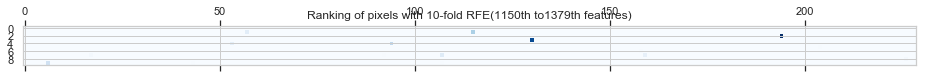

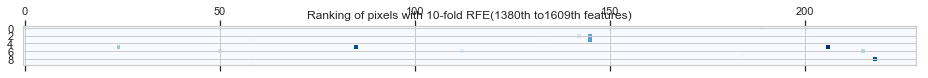

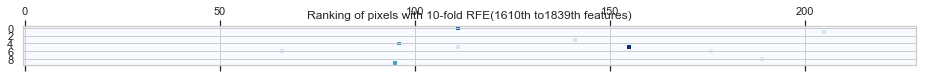

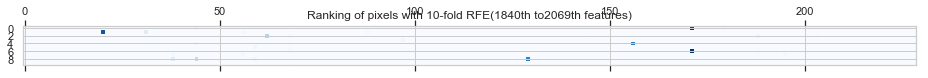

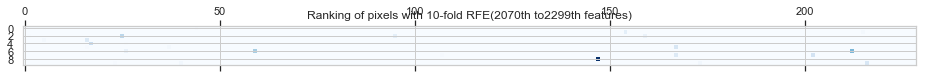

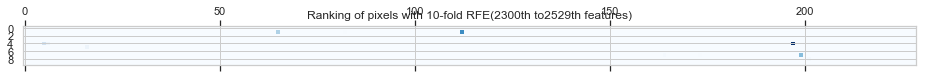

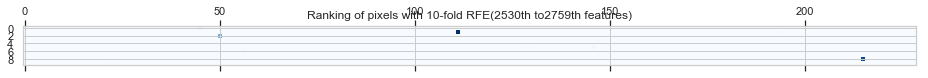

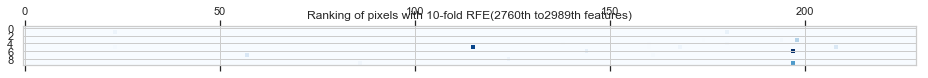

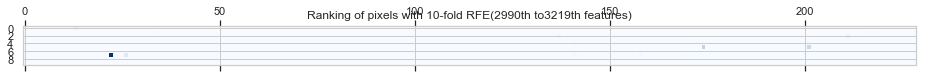

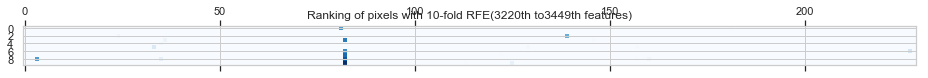

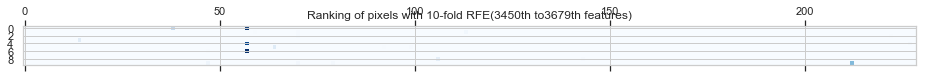

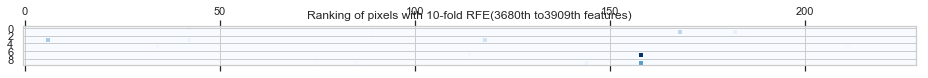

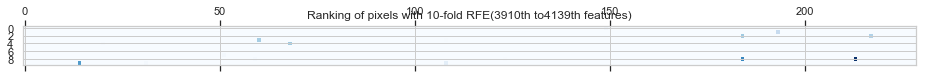

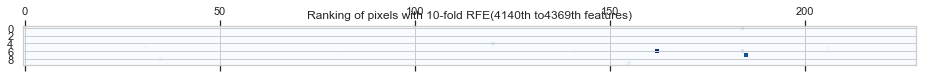

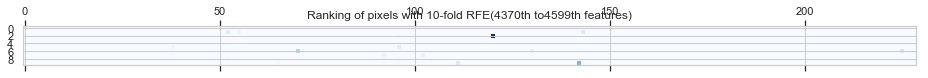

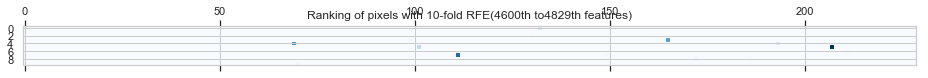

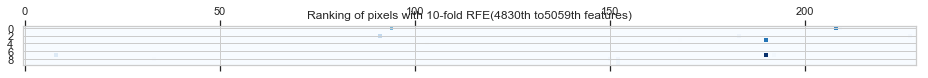

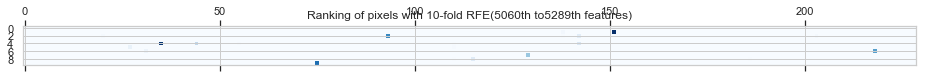

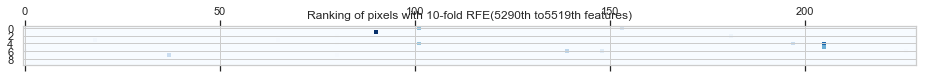

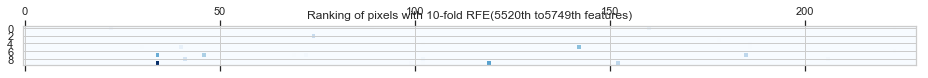

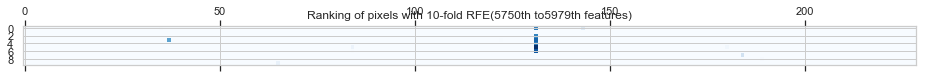

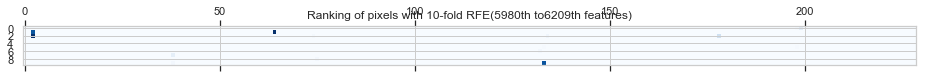

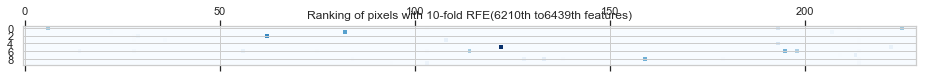

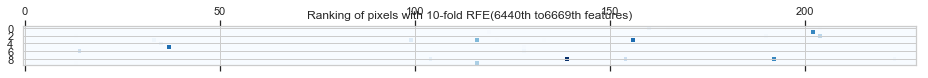

mean r2_score= -0.00463787911129071 , number of selected features= [82, 84, 28, 31, 40, 13, 16, 74, 9, 53]


In [79]:
xr2 = reg_tree(cdata, pos, 3, 90, 230)

## Feature Selection (B): Others


**RFE**

In [11]:
def rfe_(data, label, lower_n_features, upper_n_features, fig_on_row):
    X = data
    y = label
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    pbar = tnrange((upper_n_features-lower_n_features)*10, desc='loop')
    r2=[]
    mat=[]
    ilist=[]
    for train_index, test_index in kf.split(X):
        y_train, y_test = y[train_index], y[test_index]
        X_train_tmp, X_test_tmp = X[train_index], X[test_index]
        r2_single=[]
        i_single=[]
        scale = range(lower_n_features,upper_n_features)
        svr = svm.SVR(kernel='linear')
        rfe = RFE(estimator=svr, n_features_to_select=1, step=1)
        rfe.fit(X_train_tmp, y_train)
        importance = np.argsort(rfe.ranking_)
        mat.append(rfe.ranking_)
        for i in scale:
            X_train = X_train_tmp[:,importance[:i]]
            X_test = X_test_tmp[:,importance[:i]]
            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, y_train)
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
            i_single.append(i)
            pbar.update(1)
        r2.append(np.max(r2_single))
        a = np.where(r2_single==max(r2_single))[0]
        ilist.append(i_single[a[0]])
    mat = np.array(mat)
    for j in range(int(X.shape[1]/fig_on_row)):
        tmp = mat[:,j*fig_on_row:(j+1)*fig_on_row-1]
        plt.matshow(tmp, cmap=plt.cm.Blues_r)
        plt.title("Ranking of pixels with 10-fold RFE("+str(j*fig_on_row)+'th to'+str((j+1)*fig_on_row-1)+'th features)')
        plt.tight_layout
#         plt.colorbar()
    pbar.close()
    plt.show()    
    print('mean r2_score=',np.mean(r2),', number of selected features=',ilist)
    return r2

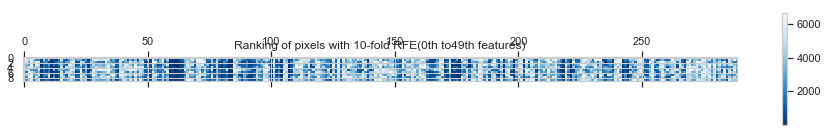

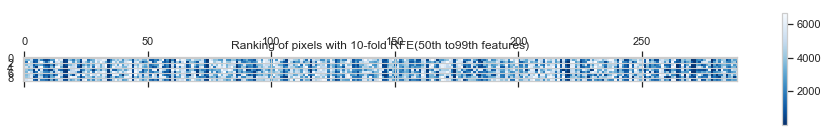

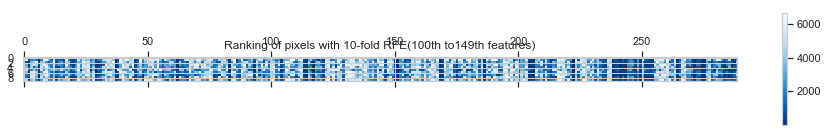

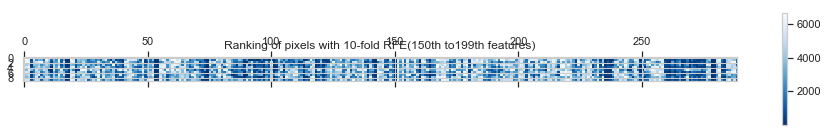

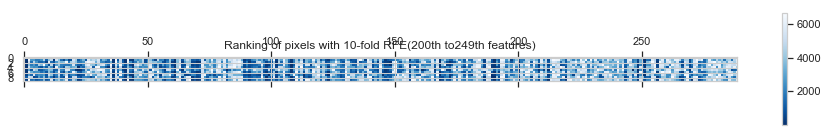

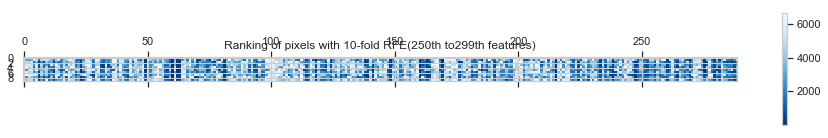

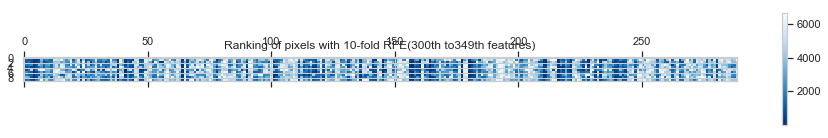

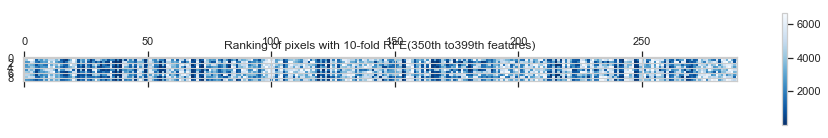

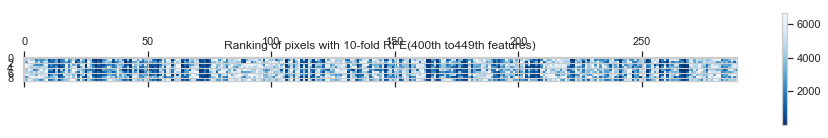

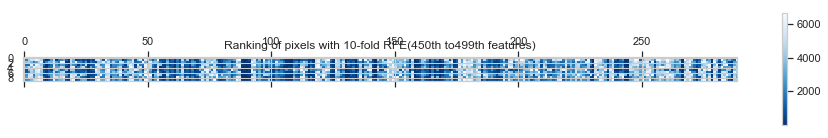

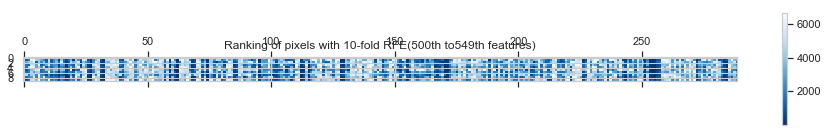

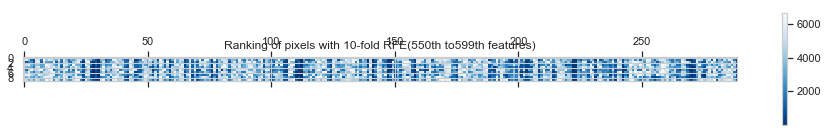

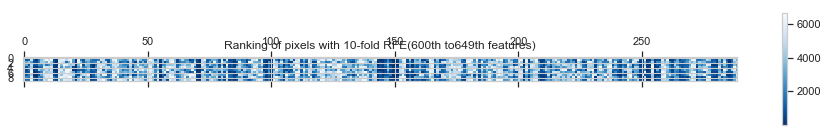

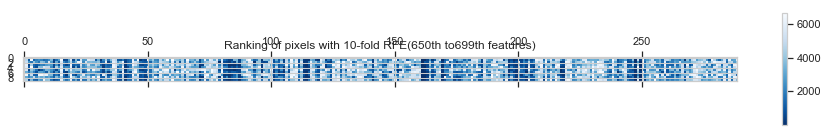

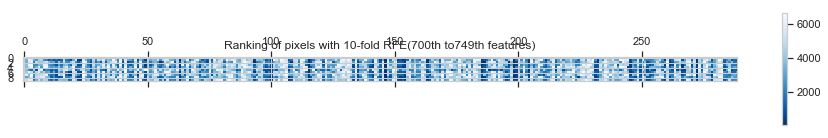

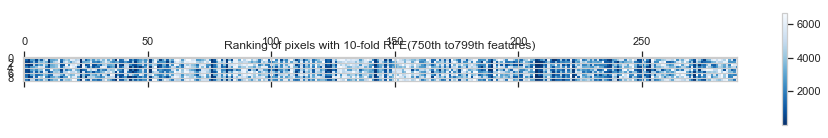

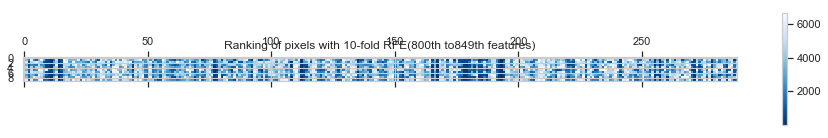

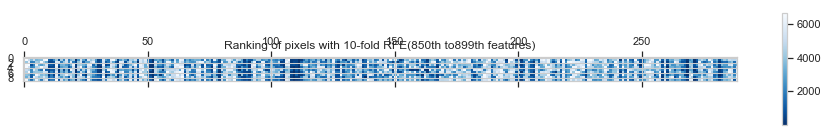

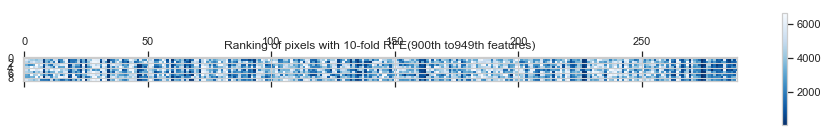

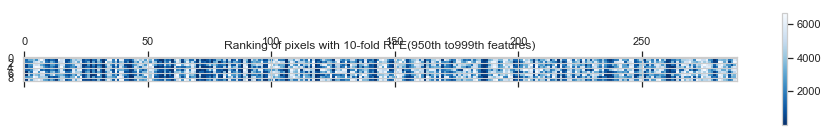

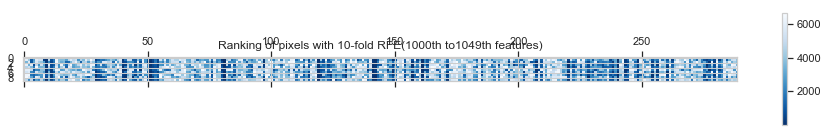

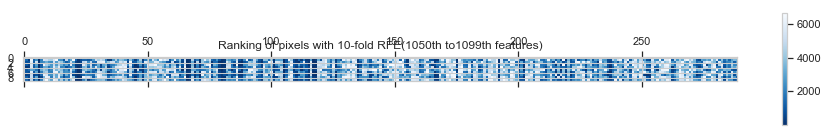

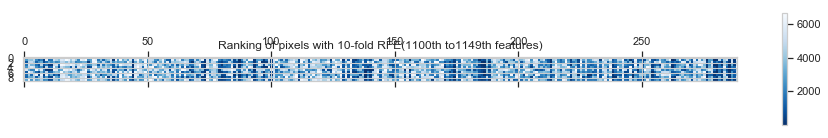

mean r2_score= -0.002733158712614392 , number of selected features= [21, 32, 61, 79, 20, 22, 34, 30, 60, 22]


In [12]:
cr2 = rfe_(cdata, pos, 20, 100, 230)

In [13]:
cr2

[-0.05770317236964018,
 0.06543369663094978,
 0.16802516120368993,
 0.33834723330626704,
 -0.286481614323596,
 -0.24063429690687466,
 -0.29062043146340133,
 -0.051755801346398345,
 0.1858377443837943,
 0.14221989375906552]

**Mutual Information**

In [95]:
def mutual_info(data, label):
    kf = KFold(n_splits=10,shuffle=True,random_state=999)
    X = data
    y = label
    r2=[]
    ilist=[]
    sublist=[]
    pbar = tnrange(40, desc='loop')
    for i in np.arange(4,8).astype(int):
        r2_single=[]
        for train_index, test_index in kf.split(X):
            y_train, y_test = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            mir = mutual_info_regression(X_train_tmp, y_train, discrete_features='auto', 
                                         n_neighbors=i, copy=True, random_state=999)
            feature_index = np.where(mir>0)[0]
            X_train = X_train_tmp[:,feature_index]
            X_test = X_test_tmp[:,feature_index]
            svr = svm.SVR(kernel='linear')
            svr.fit(X_train, np.ravel(y_train))
            r2_single.append(svr.score(X_test,np.ravel(y_test)))
            print(len(feature_index))
            pbar.update(1)
        r2.append(np.mean(r2_single))
        ilist.append(i) 
    pbar.close()
    plt.figure()
    plt.plot(np.arange(4,8),r2)
    plt.ylabel('$R^2$')
    a = np.where(r2==max(r2))[0]
    a = ilist[a[0]]
    print('max r2_score=',np.max(r2),', gamma=',a)
    return r2,ilist

3119
3286
3397
3378
3488
3559
3200
3455
3414
3105
3113
3312
3459
3342
3486
3645
3251
3498
3475
3126
3104
3256
3404
3325
3514
3632
3262
3497
3485
3177
3067
3185
3410
3268
3531
3661
3249
3507
3444
3176
max r2_score= -0.13092246047981396 , gamma= 5


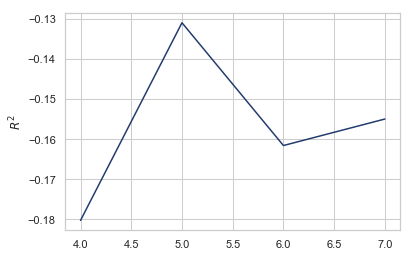

In [96]:
q,w =  mutual_info(cdata, pos)